# Import Libraries

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# for reading and displaying images
from skimage import io
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, Tanh, Hardtanh, LeakyReLU, ELU, Sigmoid, CrossEntropyLoss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as f
import torchvision.transforms as transforms
from torch.optim.swa_utils import AveragedModel, SWALR
from scipy.stats import mode
from scipy import stats, optimize

In [2]:
data = os.uname()
username = os.getlogin()
global device
if data[1] == 'lambda-dual':
    device = 'cuda:1'
    print('The model will be trained on {}'.format(device))
    data_dir = '/home/'+username+'/engrprojects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
    save_dir = '/home/'+username+'/engrprojects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/'
    print('Data will be loaded from "{}"'.format(data_dir))
    print('Data will be saved to "{}"'.format(save_dir))
elif data[1] == 'linuxg3' or data[1] == 'linuxg4':
    device = 'cuda:0'
    data_dir = '/top/projects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
    save_dir = '/top/projects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/'
    print('The model will be trained on {}'.format(device))
    print('Data will be saved to "{}"'.format(save_dir))
    

The model will be trained on cuda:1
Data will be loaded from "/home/jessew/engrprojects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/"
Data will be saved to "/home/jessew/engrprojects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/"


# Load dataset

In [3]:
# loading dataset
filenames = os.listdir(data_dir)
img_stack = []
for files in filenames:
    img = io.imread(data_dir + files)
    img_stack.append(img)

# convert images to numpy arrays
img_stack = np.asarray(img_stack)
img_stack = img_stack.astype('float32')

# get image height and width metrics
_, nx, ny, nch = img_stack.shape
print('Input dataset specs:')
print('img width = {}, img height = {}, img channels = {}'.format(nx, ny, nch))

# process the input image stack
img_stack = torch.tensor(img_stack)
img_stack = img_stack.to(device)

Input dataset specs:
img width = 681, img height = 406, img channels = 9


In [4]:
def load_batch_data(img_stack, batch_size, patch_size):
    batch_stack = []
    for i in range(0,batch_size):
        transform = transforms.RandomCrop((patch_size, patch_size))
        img_stack_p = torch.permute(img_stack, (0, 3, 1, 2))
        image_crop = transform(img_stack_p[random.randint(0,22),:,:,:])
#         print(image_crop.size)
        image_crop = torch.permute(image_crop, (1,2,0))
        batch_stack.append(image_crop)
    return batch_stack

def sort_tuple(data):
    data.sort(key = lambda x : x[0])
    return data

# Define functions

In [5]:
class ResnetBlock(Module):
    def __init__(self, channels, kernel_size, stride, padding):
        super(ResnetBlock, self).__init__()
        self.conv = Sequential(
                        Conv2d(in_channels=channels, 
                          out_channels=channels,
                          kernel_size=kernel_size,
                          stride=stride,
                          padding=padding, bias=False) )
        
    def forward(self, x):
        intermediate = self.conv(x)
        out = x + intermediate
        return out
        

class ScalableSat(Module):
    def __init__(self):
        super(ScalableSat, self).__init__()
 
        self.a = nn.parameter.Parameter(torch.Tensor([1.0,1.0,0.0]))
        self.tanh = Hardtanh()
        #self.tanh = Tanh()
        
    def forward(self,x):
        return self.a[1]*self.tanh(self.a[0]*x)+self.a[2]
    
class LeakyHardsigmoid(Module):
    def __init__(self, negative_slope=0.1):
        super(LeakyHardsigmoid,self).__init__()
        self.ns = negative_slope
        
    def forward(self,x):
        return f.leaky_relu(-f.leaky_relu(-(x-3)/6,negative_slope=self.ns)+1,negative_slope=self.ns)

class OffsetHardsigmoid(Module):
    def __init__(self):
        super(OffsetHardsigmoid,self).__init__()
        
        
    def forward(self,x):
        return f.hardsigmoid(x-3)

class OffsetLeakyHardsigmoid(Module):
    def __init__(self):
        super(OffsetLeakyHardsigmoid,self).__init__()
        
        
    def forward(self,x):
        return f.rrelu(-f.rrelu(-(x-1),lower=0)+1,lower=0)
    
class AbsActivation(Module):
    def __init__(self):
        super(AbsActivation,self).__init__()
        
    def forward(self,x):
        return torch.abs(x)

class NormalizeEndmembers(Module):
    def forward(self,X):
        return X / X.norm(dim=0)
            
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        w=32
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch, w, kernel_size=3, stride=1, padding=1,bias=False),
            ReLU(),
#             BatchNorm2d(64),
#             Dropout(0.2),
            Conv2d(w, w, kernel_size=1, stride=1, padding=0,bias=False),
            ReLU(),
#             BatchNorm2d(64),
#             Dropout(0.2),
            Conv2d(w, w, kernel_size=1, stride=1, padding=0,bias=False),
            ReLU(),
#             BatchNorm2d(64),
#             Dropout(0.2),
            Conv2d(w, w, kernel_size=1, stride=1, padding=0,bias=False),
            ReLU(),
#             BatchNorm2d(64),
#             Dropout(0.2),
            Conv2d(w, w, kernel_size=1, stride=1, padding=0,bias=False),
            ReLU(),
#             BatchNorm2d(64),
#             Dropout(0.2),
            
            # Defining additional 2D convolution layer
            Conv2d(w, nch_bottleneck, kernel_size=1, stride=1, padding=0, bias=False),
            
#             nn.Sigmoid(),
            # implementing the v-notch nonlinearity
            nn.Hardtanh(),
            AbsActivation()
            #ReLU()
        )
        
        self.cnn_spectral_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch_bottleneck, nch, kernel_size=1, stride=1,bias=False),  
            ScalableSat()
        )
       
        
        self.cnn_layers.apply(initialize_weights_kaiming)
        self.cnn_spectral_layers.apply(initialize_weights_endmembers)
    
        nn.utils.parametrize.register_parametrization(self.cnn_spectral_layers[0],"weight",NormalizeEndmembers())
        
        
        
    def getSOEMlayer(self):
        return self.cnn_spectral_layers[0]
    
    # Defining the forward pass    
    def forward(self, x):
        z = self.cnn_layers(x)
        y = self.cnn_spectral_layers(z)
        return y
    
    def forward_enc(self, x):
        z = self.cnn_layers(x)
        return z
    
    def forward_dec(self, z):
        y = self.cnn_spectral_layers(z)
        return y
    
def initialize_weights_kaiming(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)
        
def initialize_weights_endmembers(m):
    # brownian bridge
    # brownian motion that starts and ends on zero, matching realistic constraints for transient responses
    # equation credit: Diego Krapf
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data,mean=10.)
        #nn.init.uniform_(m.weight.data)
        with torch.no_grad():
            m.weight.data = torch.cumsum(m.weight.data,dim=0)
            m.weight.data[0,:]=0
            m.weight.data = m.weight.data - torch.linspace(0,1,9)[:,None,None,None]*m.weight.data[-1,:]

        

# define latent space visualization function
def visualize_z(ind):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(1.2*img[:,:,0:3])
    plt.show()
    return img

# define latent space visualization function
def generate_z_image(model, ind, indices):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,indices[0:3],:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    return 1.*img

def visualSummary(model, L1_loss, indices):
    plt.figure(figsize=(12,6))
    plt.subplot(2,3,(1,4))
    img1 = generate_z_image(model,0, indices)
    plt.imshow(img1)
    plt.subplot(2,3,(2,5))
    img2 = generate_z_image(model,1, indices)
    plt.imshow(img2)
    plt.subplot(2,3,3)
    w = model.getSOEMlayer().weight
    w = w.detach().cpu().numpy().squeeze()
    tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
    plt.plot(tau, w[:,indices[0]], 'r')
    plt.plot(tau, w[:,indices[1]], 'g')
    plt.plot(tau, w[:,indices[2]], 'b')
#     plt.plot(tau, w[:,indices[3]], 'y')
#     plt.plot(tau, w[:,indices[4]], 'c')
    plt.title('recovered endmembers')
    plt.xlabel('probe delay, ps')
    plt.subplot(2,3,6)
    plt.plot(L1_loss)
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('L1 Loss')
    plt.tight_layout()
    plt.show()
    return img1, img2
    
# Custom Loss Functions
def meansq(x):
    return torch.mean((x-torch.mean(x))**2)

def corr(x,y):
    return torch.sum(x*y) / (torch.sqrt(torch.sum(x**2))*torch.sqrt(torch.sum(y**2)))

def SADLoss(weights):
    deriv = torch.nn.Parameter(weights[1:,]-weights[:-1,])
    sad = torch.sum(deriv**2)
    return sad

def channelCorrelationLoss(z):
    # inter-channel correlation loss
    zvec = z.squeeze().view(nch_bottleneck,-1)
    zvec = zvec-torch.mean(zvec,1,keepdim=True)
    zcov = torch.matmul(zvec,zvec.transpose(0,1))
    zstds = torch.sqrt(zcov.diag()).expand(1,-1)
    zstdprods = torch.matmul(zstds.transpose(0,1),zstds)
    zcorrabs = zcov / (zstdprods + 1e-6)
    #zcorrabs = torch.max(zcorrabs, torch.tensor(0.5))
    loss_zcorr = (torch.sum(f.relu(zcorrabs.triu())) - zcorrabs.trace())
    #loss_zcorr += (torch.sum(f.relu(zcov.triu())) - zcov.trace())
    #loss_zcorr = (torch.sum((zcorrabs.triu())) - zcorrabs.trace())
    
    return loss_zcorr

def channelCrossEntropyLoss(z):
    zvec = z.squeeze().view(nch_bottleneck,-1)
    print(zvec.shape)
    loss = f.cross_entropy(zvec[None,0,:],zvec[None,1,:])
    loss += f.cross_entropy(zvec[0,:],zvec[2,:])
    loss += f.cross_entropy(zvec[1,:],zvec[2,:])
    loss = -1.0 * loss
    return loss

    

# model training routine definition
def train_model(model, n_epochs, img_stack, lr):
    
    # define loss function
    criterion = nn.MSELoss()
    
    # define optimizer
    #optimizer = torch.optim.Adam([{'params':model.cnn_layers.parameters()},
    #                              {'params':model.cnn_spectral_layers.parameters(),'lr':lr/10.}],
    #                             lr,amsgrad=True)
    optimizer = torch.optim.Adam(model.parameters(),lr)
    #optimizer = torch.optim.AdamW(model.parameters(),lr)
    #optimizer=torch.optim.RMSprop(model.parameters(),lr)
    #optimizer = torch.optim.Adadelta(model.parameters(),lr)
    #optimizer = torch.optim.Adagrad(model.parameters(),lr)
    #optimizer = torch.optim.SGD(model.parameters(),lr)
    
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',factor=0.9)
    #scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer,lr_lambda= lambda epoch: 0.99)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=n_epochs,eta_min=0)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=0.01,total_steps=n_epochs*len(img_stack))
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,50)
    
    
    # initialize model weights and send to train device
    model.to(device) # load the model in the training device
    
    # apply initialization
    
    # define variables
    total_loss = []
    
        
    # iterate over the epochs
    for epoch in tqdm(range(1, n_epochs+1)):
        
        # monitor training loss
        train_loss = 0.0
        loss_recon_avg = 0.
        loss_zcorr_avg = 0.
        
        # keep track of meansq value for each channel
        channelmsq = torch.zeros(nch_bottleneck).to(device)
        
        #Training       
#         current_batch = load_batch_data(img_stack, 150, patch_size)
        
        img_stack_shuffle  = img_stack[torch.randperm(len(img_stack))]
        for images in img_stack_shuffle:
        #for images in img_stack:
        
            images = images[None, :]
            image_x_p = torch.permute(images, (0, 3, 1, 2))
            image_x_p = image_x_p.to(device)
            optimizer.zero_grad()         
            z = model.forward_enc(image_x_p)
            outputs = model.forward_dec(z)


            # calculate the weighted spectral angular divergence (SAD) loss
    #             in_product = torch.sum(torch.mul(image_x_p, outputs), dim = 1)
    #             self_product = torch.sqrt(torch.sum(torch.mul(image_x_p, image_x_p), dim = 1)) * torch.sqrt(torch.sum(torch.mul(outputs, outputs), dim =1))            
    #             cos_theta = torch.div(in_product, self_product)
    #             theta = torch.acos(cos_theta)
    #             mSAD = torch.mean(theta)

    #             cos = nn.CosineSimilarity(dim=1, eps=1e-8)
    #             cos_loss = torch.mean(torch.acos(cos(image_x_p, outputs)))

            # variance-ordering
            channelmsq += torch.mean(z**2,dim=[2,3]).squeeze()

            # stack sum-squared
            ssq = torch.sum(image_x_p**2, dim = 1)
            ssq = f.avg_pool2d(ssq,kernel_size=3,stride=1,padding=1)
            ssq = ssq/ torch.max(ssq)
    #             print('ssq:', ssq)

            # calculate the weighted L1 loss
            err_stack = image_x_p - outputs
            chan_weights = 1/torch.std(image_x_p,dim=(2,3))
            chan_weights = chan_weights / torch.sum(chan_weights)
            chan_weights[0] = 0.1
            l1_err_per_chan = torch.mean(torch.abs(err_stack),dim=(2,3))
            spectral_weighted_l1 = torch.mean(chan_weights * l1_err_per_chan)


            loss_recon = criterion(image_x_p, outputs)
            #loss_recon = torch.mean(ssq*(err_stack**2))

            # interchannel correlation loss
            loss_zcorr = channelCorrelationLoss(z)
            #zdown2 = f.avg_pool2d(z,kernel_size=16,stride=1)
            #loss_zcorr = channelCorrelationLoss(zdown2)
            
            #loss_hoyer = torch.mean(torch.sum(torch.abs(ssq*z),dim=1)**2 / (torch.sum((ssq*z)**2,dim=1)+0.001))
    
            # total loss
            #loss = loss_recon + lambda_zcorr * loss_zcorr
            #loss = spectral_weighted_l1 * loss_zcorr
            #loss = loss_recon * loss_zcorr
            #loss = loss_recon + 0.01 * loss_zcorr
            loss = spectral_weighted_l1 + 0.001*loss_zcorr;
            #loss = loss_recon
            loss.backward()
            optimizer.step()
            #scheduler.step(loss)

            train_loss += loss.item()*image_x_p.size(0)
            
            loss_recon_avg += loss_recon
            loss_zcorr_avg += loss_zcorr
            
            
        train_loss = train_loss/len(img_stack)
        total_loss.append(train_loss)
        
        loss_recon_avg = loss_recon_avg / len(img_stack)
        loss_zcorr_avg = loss_zcorr_avg / len(img_stack)
        
        #scheduler.step()
        
        # rearrange channels so red has max variance, blue the least
        model.indices = channelmsq.argsort(descending=True)
        
        #if epoch%50 == 0:
        #if (epoch > 100) and (train_loss == np.min(total_loss)):
        img1 = 0
        img2 = 0
        #    img1, img2 = visualSummary(model,total_loss, model.indices)
        #    print('recon loss: ', loss_recon_avg.item(), ', zcorr loss: ', loss_zcorr_avg.item())
        
    return total_loss[-1], img1, img2, loss_recon_avg, loss_zcorr_avg


In [6]:
np.random.rand()

0.2149090106662337

# Train model

In [7]:
loss_arr = []

# number of times the experiment is repeated
n_runs = 500
n_epochs = 200
learning_rate = 1e-2
nch_bottleneck = 4

loss_recon_arr = np.zeros(n_runs)
loss_zcorr_arr = np.zeros(n_runs)


print('Starting training of models on {}'.format(device))
n_count = 0
models = [Net() for i in range(n_runs)]
for i in range(1,n_runs+1):
    #model = Net()
    loss, img1, img2, loss_recon, loss_zcorr = train_model(models[i-1], n_epochs, img_stack, learning_rate)
    loss_arr.append((loss, img1, img2))
    loss_recon_arr[i-1] = loss_recon
    loss_zcorr_arr[i-1] = loss_zcorr
    n_count+=1
    print('Runs done: {}/{}'.format(n_count, n_runs))

Starting training of models on cuda:1


100%|██████████| 200/200 [00:30<00:00,  6.57it/s]


Runs done: 1/500


100%|██████████| 200/200 [00:28<00:00,  6.95it/s]


Runs done: 2/500


100%|██████████| 200/200 [00:28<00:00,  6.93it/s]


Runs done: 3/500


100%|██████████| 200/200 [00:29<00:00,  6.89it/s]


Runs done: 4/500


100%|██████████| 200/200 [00:29<00:00,  6.85it/s]


Runs done: 5/500


100%|██████████| 200/200 [00:29<00:00,  6.69it/s]


Runs done: 6/500


100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


Runs done: 7/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 8/500


100%|██████████| 200/200 [00:29<00:00,  6.70it/s]


Runs done: 9/500


100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


Runs done: 10/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 11/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 12/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 13/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 14/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 15/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 16/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 17/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 18/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 19/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 20/500


100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


Runs done: 21/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 22/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 23/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 24/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 25/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 26/500


100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


Runs done: 27/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 28/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 29/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 30/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 31/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 32/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 33/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 34/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 35/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 36/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 37/500


100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


Runs done: 38/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 39/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 40/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 41/500


100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


Runs done: 42/500


100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


Runs done: 43/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 44/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 45/500


100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


Runs done: 46/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 47/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 48/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 49/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 50/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 51/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 52/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 53/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 54/500


100%|██████████| 200/200 [00:30<00:00,  6.63it/s]


Runs done: 55/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 56/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 57/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 58/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 59/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 60/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 61/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 62/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 63/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 64/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 65/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 66/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 67/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 68/500


100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


Runs done: 69/500


100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


Runs done: 70/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 71/500


100%|██████████| 200/200 [00:30<00:00,  6.64it/s]


Runs done: 72/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 73/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 74/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 75/500


100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


Runs done: 76/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 77/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 78/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 79/500


100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


Runs done: 80/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 81/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 82/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 83/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 84/500


100%|██████████| 200/200 [00:30<00:00,  6.67it/s]


Runs done: 85/500


100%|██████████| 200/200 [00:29<00:00,  6.68it/s]


Runs done: 86/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 87/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 88/500


100%|██████████| 200/200 [00:30<00:00,  6.63it/s]


Runs done: 89/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 90/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 91/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 92/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 93/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 94/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 95/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 96/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 97/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 98/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 99/500


100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


Runs done: 100/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 101/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 102/500


100%|██████████| 200/200 [00:30<00:00,  6.63it/s]


Runs done: 103/500


100%|██████████| 200/200 [00:30<00:00,  6.63it/s]


Runs done: 104/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 105/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 106/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 107/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 108/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 109/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 110/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 111/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 112/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 113/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 114/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 115/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 116/500


100%|██████████| 200/200 [00:29<00:00,  6.67it/s]


Runs done: 117/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 118/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 119/500


100%|██████████| 200/200 [00:30<00:00,  6.64it/s]


Runs done: 120/500


100%|██████████| 200/200 [00:30<00:00,  6.63it/s]


Runs done: 121/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 122/500


100%|██████████| 200/200 [00:29<00:00,  6.70it/s]


Runs done: 123/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 124/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 125/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 126/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 127/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 128/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 129/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 130/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 131/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 132/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 133/500


100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


Runs done: 134/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 135/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 136/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 137/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 138/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 139/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 140/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 141/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 142/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 143/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 144/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 145/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 146/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 147/500


100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


Runs done: 148/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 149/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 150/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 151/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 152/500


100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


Runs done: 153/500


100%|██████████| 200/200 [00:30<00:00,  6.67it/s]


Runs done: 154/500


100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


Runs done: 155/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 156/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 157/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 158/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 159/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 160/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 161/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 162/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 163/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 164/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 165/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 166/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 167/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 168/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 169/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 170/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 171/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 172/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 173/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 174/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 175/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 176/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 177/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 178/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 179/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 180/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 181/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 182/500


100%|██████████| 200/200 [00:30<00:00,  6.64it/s]


Runs done: 183/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 184/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 185/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 186/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 187/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 188/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 189/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 190/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 191/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 192/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 193/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 194/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 195/500


100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


Runs done: 196/500


100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


Runs done: 197/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 198/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 199/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 200/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 201/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 202/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 203/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 204/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 205/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 206/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 207/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 208/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 209/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 210/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 211/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 212/500


100%|██████████| 200/200 [00:29<00:00,  6.67it/s]


Runs done: 213/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 214/500


100%|██████████| 200/200 [00:30<00:00,  6.64it/s]


Runs done: 215/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 216/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 217/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 218/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 219/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 220/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 221/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 222/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 223/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 224/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 225/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 226/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 227/500


100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


Runs done: 228/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 229/500


100%|██████████| 200/200 [00:30<00:00,  6.64it/s]


Runs done: 230/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 231/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 232/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 233/500


100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


Runs done: 234/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 235/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 236/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 237/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 238/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 239/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 240/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 241/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 242/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 243/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 244/500


100%|██████████| 200/200 [00:29<00:00,  6.67it/s]


Runs done: 245/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 246/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 247/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 248/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 249/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 250/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 251/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 252/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 253/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 254/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 255/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 256/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 257/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 258/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 259/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 260/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 261/500


100%|██████████| 200/200 [00:29<00:00,  6.67it/s]


Runs done: 262/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 263/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 264/500


100%|██████████| 200/200 [00:29<00:00,  6.68it/s]


Runs done: 265/500


100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


Runs done: 266/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 267/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 268/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 269/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 270/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 271/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 272/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 273/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 274/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 275/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 276/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 277/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 278/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 279/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 280/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 281/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 282/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 283/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 284/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 285/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 286/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 287/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 288/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 289/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 290/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 291/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 292/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 293/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 294/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 295/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 296/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 297/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 298/500


100%|██████████| 200/200 [00:29<00:00,  6.70it/s]


Runs done: 299/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 300/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 301/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 302/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 303/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 304/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 305/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 306/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 307/500


100%|██████████| 200/200 [00:29<00:00,  6.70it/s]


Runs done: 308/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 309/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 310/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 311/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 312/500


100%|██████████| 200/200 [00:30<00:00,  6.63it/s]


Runs done: 313/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 314/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 315/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 316/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 317/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 318/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 319/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 320/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 321/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 322/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 323/500


100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


Runs done: 324/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 325/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 326/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 327/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 328/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 329/500


100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


Runs done: 330/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 331/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 332/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 333/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 334/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 335/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 336/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 337/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 338/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 339/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 340/500


100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


Runs done: 341/500


100%|██████████| 200/200 [00:30<00:00,  6.63it/s]


Runs done: 342/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 343/500


100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


Runs done: 344/500


100%|██████████| 200/200 [00:30<00:00,  6.63it/s]


Runs done: 345/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 346/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 347/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 348/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 349/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 350/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 351/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 352/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 353/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 354/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 355/500


100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


Runs done: 356/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 357/500


100%|██████████| 200/200 [00:30<00:00,  6.63it/s]


Runs done: 358/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 359/500


100%|██████████| 200/200 [00:30<00:00,  6.61it/s]


Runs done: 360/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 361/500


100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


Runs done: 362/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 363/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 364/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 365/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 366/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 367/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 368/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 369/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 370/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 371/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 372/500


100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


Runs done: 373/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 374/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 375/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 376/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 377/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 378/500


100%|██████████| 200/200 [00:29<00:00,  6.70it/s]


Runs done: 379/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 380/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 381/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 382/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 383/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 384/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 385/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 386/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 387/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 388/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 389/500


100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


Runs done: 390/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 391/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 392/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 393/500


100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


Runs done: 394/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 395/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 396/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 397/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 398/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 399/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 400/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 401/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 402/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 403/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 404/500


100%|██████████| 200/200 [00:29<00:00,  6.67it/s]


Runs done: 405/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 406/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 407/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 408/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 409/500


100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


Runs done: 410/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 411/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 412/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 413/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 414/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 415/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 416/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 417/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 418/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 419/500


100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


Runs done: 420/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 421/500


100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


Runs done: 422/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 423/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 424/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 425/500


100%|██████████| 200/200 [00:30<00:00,  6.64it/s]


Runs done: 426/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 427/500


100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


Runs done: 428/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 429/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 430/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 431/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 432/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 433/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 434/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 435/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 436/500


100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


Runs done: 437/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 438/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 439/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 440/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 441/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 442/500


100%|██████████| 200/200 [00:29<00:00,  6.69it/s]


Runs done: 443/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 444/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 445/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 446/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 447/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 448/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 449/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 450/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 451/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 452/500


100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


Runs done: 453/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 454/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 455/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 456/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 457/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 458/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 459/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 460/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 461/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 462/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 463/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 464/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 465/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 466/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 467/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 468/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 469/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 470/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 471/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 472/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 473/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 474/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 475/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 476/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 477/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 478/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 479/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 480/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 481/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 482/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 483/500


100%|██████████| 200/200 [00:29<00:00,  6.70it/s]


Runs done: 484/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 485/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 486/500


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Runs done: 487/500


100%|██████████| 200/200 [00:30<00:00,  6.62it/s]


Runs done: 488/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 489/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 490/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 491/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 492/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 493/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 494/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 495/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 496/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Runs done: 497/500


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Runs done: 498/500


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Runs done: 499/500


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]

Runs done: 500/500


# Analyze distribution of recovered endmembers

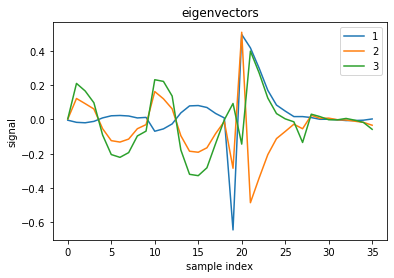

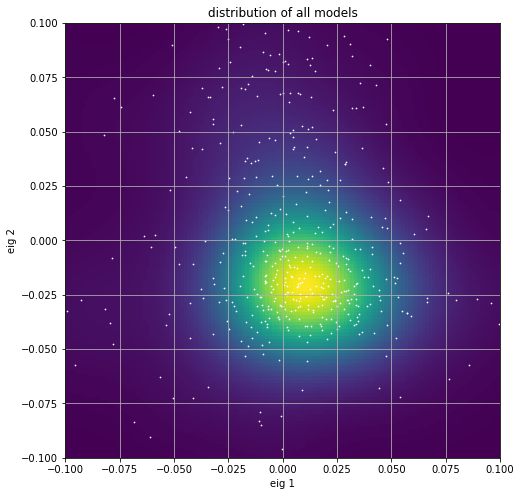

0.9960205595339428
(3, 500)


In [110]:
# generate endmember list
wlist = np.zeros((len(models),9,nch_bottleneck))
for i,model in enumerate(models):
    w = model.getSOEMlayer().weight
    w = w[:,model.indices]
    w = w.detach().cpu().numpy().squeeze()
    wlist[i,:,:] = w
    
wlist = wlist.swapaxes(2,1).reshape([n_runs,9*nch_bottleneck])
wlist[np.isnan(wlist)] = 0

# subtract off means of each column
wmeans = np.mean(wlist,axis=0)
wlistms = wlist - wmeans

# singular value decomposition
u,s,vh = np.linalg.svd(wlistms)

plt.plot(vh[0:3,:].transpose())
plt.xlabel('sample index')
plt.ylabel('signal')
plt.title('eigenvectors')
plt.legend(['1','2','3'])
plt.show()

pltrange= 0.1

# distribution, eigs1 vs 2
plt.figure(figsize=(8,8))
x = np.linspace(-pltrange,pltrange,128)
y = np.linspace(-pltrange,pltrange,128)
#z = np.linspace(-pltrange,pltrange,128)
X,Y = np.meshgrid(x,y)
Z = np.zeros_like(X)
xylist = np.vstack([X.ravel(),Y.ravel(),Z.ravel()])
kernel = stats.gaussian_kde(u[0:3,:])
D = np.reshape(kernel(xylist).T,X.shape)

plt.imshow(D,origin='lower',extent=[x[0],x[-1],y[0],y[-1]])                 

#plt.imshow(H.T,interpolation='nearest',origin='lower',extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]])
plt.scatter(u[0,:],u[1,:],0.5,marker='o',color='white',alpha=1.0)
plt.xlim((-pltrange,pltrange))
plt.ylim((-pltrange,pltrange))
plt.grid()
plt.xlabel('eig 1')
plt.ylabel('eig 2')
plt.title('distribution of all models')
plt.show()


# relative probability of each model
kdeint = kernel.integrate_box([-0.5,-0.5,-0.5],[0.5,0.5,0.5])
print(kdeint)
relprob = kernel.pdf(u[0:3,:])
print(u[0:3,:].shape)
relprob = relprob / np.sum(relprob)


In [ ]:
counts,edges=np.histogram(loss_recon_arr,128)
loss_recon_w = np.sum(relprob*loss_recon_arr)
print('probability-weighted recon loss: ', loss_recon_w)
loss_recon_ml = edges[np.argmax(counts)]
print('most likely recon loss: ', loss_recon_ml)
#aic = 9*np.log(loss_recon_ml)+2*nch_bottleneck
aic = 9*np.log(loss_recon_ml)+9*nch_bottleneck+3
print('AIC: ', aic)

plt.plot(edges[1:],counts)
plt.vlines(loss_recon_w,0,max(counts))
plt.xlabel('reconstruction loss')
plt.ylabel('model count')
plt.title('reconstruction loss histogram')
plt.plot()

loss_recon_w = np.sum(relprob*loss_recon_arr)


In [ ]:
np.max(relprob)

In [ ]:
counts,edges=np.histogram(relprob,128)
plt.plot(edges[1:],counts)
plt.show()
print(np.percentile(relprob,90))
print(np.max(relprob))
print(np.argwhere(relprob > np.percentile(relprob,90)))

# Estimate endmembers and abundances based on relative probability weighting of models

(9, 4)


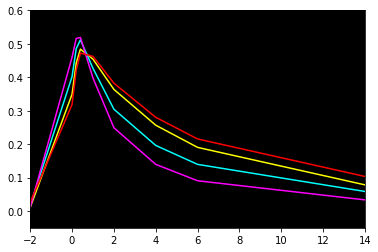

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


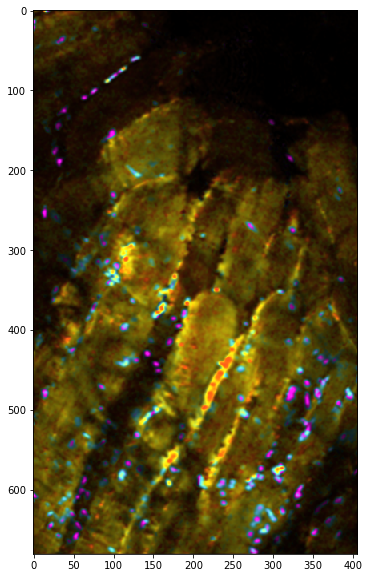

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


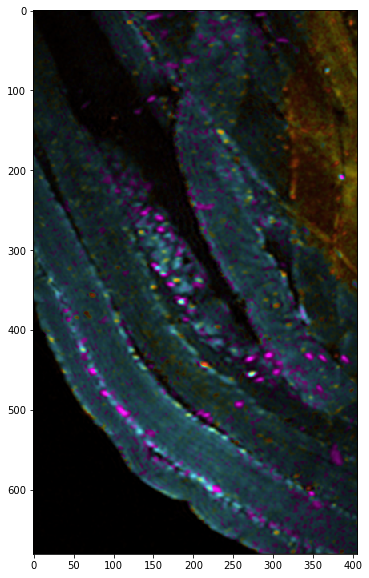

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


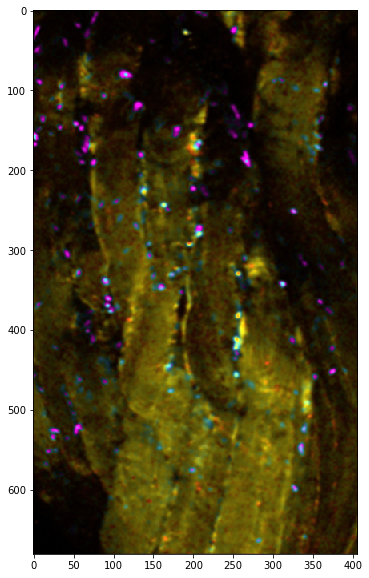

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


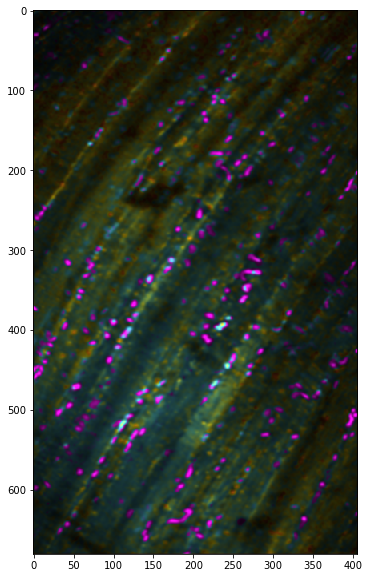

In [111]:
def generate_z_image_ensembled(ind, models):
    nb,ny,nx,nch = img_stack.shape
    img = np.zeros((len(models),ny,nx,nch_bottleneck))
    for i, model in enumerate(models):
        data = img_stack[ind,:,:,:]
        data = data[None,:]
        data = data.to(device)
        out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
        out = out[0,model.indices[0:nch_bottleneck],:,:]
        out = torch.permute(out, (1,2,0))
        img[i] = relprob[i]*out.detach().cpu().numpy()
        #img[i] = out.detach().cpu().numpy()
        
    #img = img/len(models)
    #img = np.mean(img,axis=0).squeeze()
    img[np.isnan(img)]=0
    img = np.sum(img,axis=0).squeeze()
    #nbin = 50
    #ret = mode((nbin*img).astype(np.int),axis=0)
    #img = ret.mode.astype(np.float)/nbin
    
    ny,nx,nch = img.shape
    img_recolor = np.zeros((ny,nx,3))
    img_recolor[:,:,0] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,1]
    img_recolor[:,:,2] += img[:,:,1]
    if nch_bottleneck > 2:
        img_recolor[:,:,2] += img[:,:,2]
        img_recolor[:,:,0] += img[:,:,2]
    if nch_bottleneck > 3:
        img_recolor[:,:,0] += img[:,:,3]
    #img_recolor[:,:,1] += img[:,:,4]
    return img_recolor

def generate_w_ensembled(models):
    wlist = np.zeros((len(models),9,nch_bottleneck))
    for i,model in enumerate(models):
        w = model.getSOEMlayer().weight
        w = w[:,model.indices]
        w = w.detach().cpu().numpy().squeeze()
        w[np.isnan(w)]=0
        wlist[i,:,:] = relprob[i] * w
        #
        
    return np.sum(wlist,axis=0)
    #return wlist
        
        
tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
w = generate_w_ensembled(models)
print(w.shape)
alph = 20/len(models)
#alph=0.03
ax=plt.axes()
ax.set_facecolor('black')
plt.plot(tau,w[:,0],color='yellow')
plt.plot(tau,w[:,1],color='cyan')
if nch_bottleneck > 2:
    plt.plot(tau,w[:,2],color='magenta')
if nch_bottleneck > 3:
    plt.plot(tau,w[:,3],color='red')
    #
#for i in range(len(models)):
#    plt.plot(tau,w[i,:,0],color='yellow',alpha=alph)
#    plt.plot(tau,w[i,:,1],color='cyan',alpha=alph)
#    plt.plot(tau,w[i,:,2],color='magenta',alpha=alph)
    #plt.plot(tau,w[i,:,3],color='red',alpha=alph)
    #plt.plot(tau,w[i,:,4],color='green',alpha=2*alph)
ax.set_xlim([-2,14])
ax.set_ylim([-0.05,0.6])
plt.show()
                     

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_ensembled(0,models))
plt.show()

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_ensembled(1,models))
plt.show()

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_ensembled(2,models))
plt.show()

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_ensembled(5,models))
plt.show()

# Endmembers and abundances based on most likely model

most likely model:  408
AIC:  -67.46487118642654


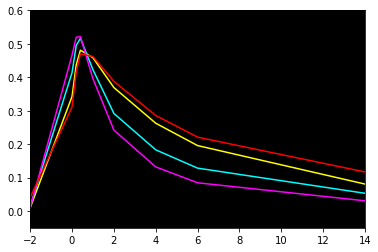

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


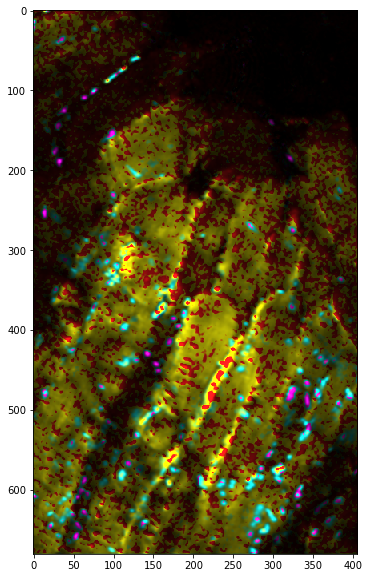

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


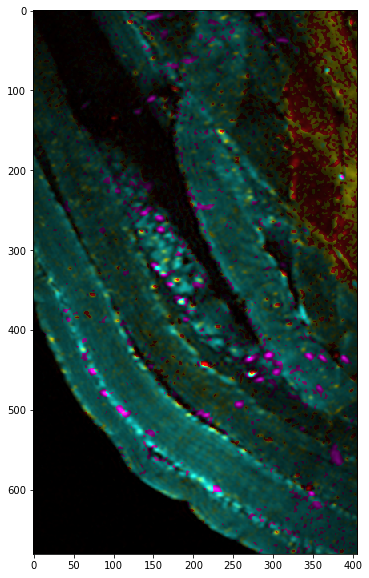

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


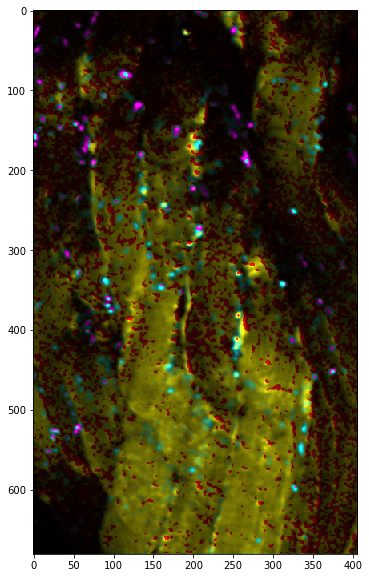

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


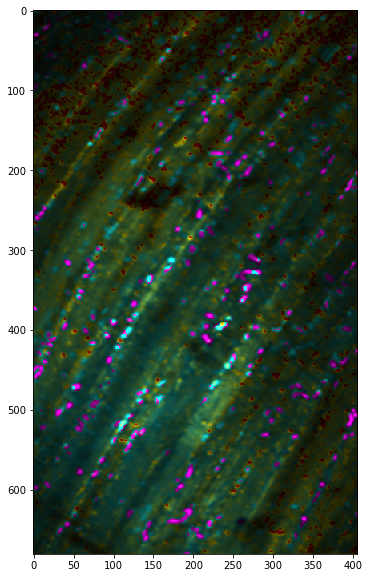

In [20]:

def generate_z_image_onemodel(ind, model):
    nb,ny,nx,nch = img_stack.shape
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,model.indices[0:nch_bottleneck],:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    
    ny,nx,nch = img.shape
    img_recolor = np.zeros((ny,nx,3))
    img_recolor[:,:,0] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,1]
    img_recolor[:,:,2] += img[:,:,1]
    if nch_bottleneck > 2:
        img_recolor[:,:,2] += img[:,:,2]
        img_recolor[:,:,0] += img[:,:,2]
    if nch_bottleneck > 3:
        img_recolor[:,:,0] += img[:,:,3]
    #img_recolor[:,:,1] += img[:,:,4]
    return img_recolor

def generate_w_onemodel(model):
    w = model.getSOEMlayer().weight
    w = w[:,model.indices]
    w = w.detach().cpu().numpy().squeeze()
    return w

ind_ml = np.argmax(relprob)
print('most likely model: ', ind_ml)

#aic = 9*np.log(loss_recon_arr[ind_ml])+2*nch_bottleneck
aic = 9*np.log(loss_recon_arr[ind_ml])+2*(9*nch_bottleneck)
print('AIC: ', aic)

tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
w = generate_w_onemodel(models[ind_ml])

ax=plt.axes()
ax.set_facecolor('black')
plt.plot(tau,w[:,0],color='yellow')
plt.plot(tau,w[:,1],color='cyan')
if nch_bottleneck > 2:
    plt.plot(tau,w[:,2],color='magenta')
if nch_bottleneck > 3:
    plt.plot(tau,w[:,3],color='red')
    #
#for i in range(len(models)):
#    plt.plot(tau,w[i,:,0],color='yellow',alpha=alph)
#    plt.plot(tau,w[i,:,1],color='cyan',alpha=alph)
#    plt.plot(tau,w[i,:,2],color='magenta',alpha=alph)
    #plt.plot(tau,w[i,:,3],color='red',alpha=alph)
    #plt.plot(tau,w[i,:,4],color='green',alpha=2*alph)
ax.set_xlim([-2,14])
ax.set_ylim([-0.05,0.6])
plt.show()
                     

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_onemodel(0,models[ind_ml]))
plt.show()

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_onemodel(1,models[ind_ml]))
plt.show()

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_onemodel(2,models[ind_ml]))
plt.show()

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_onemodel(5,models[ind_ml]))
plt.show()

# Average top most likely models

50
(9, 4)


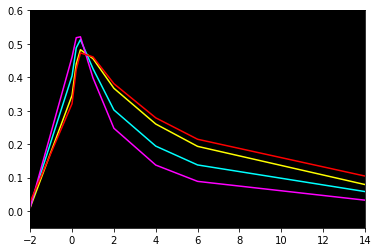

50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


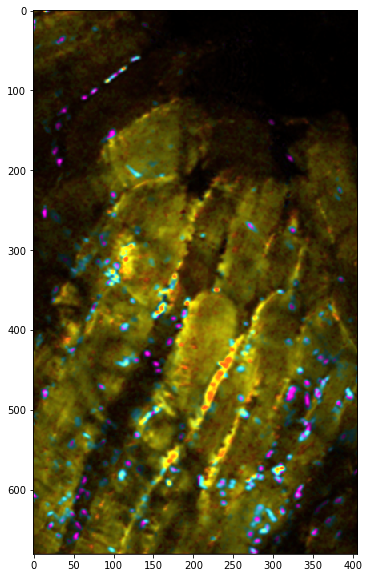

50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


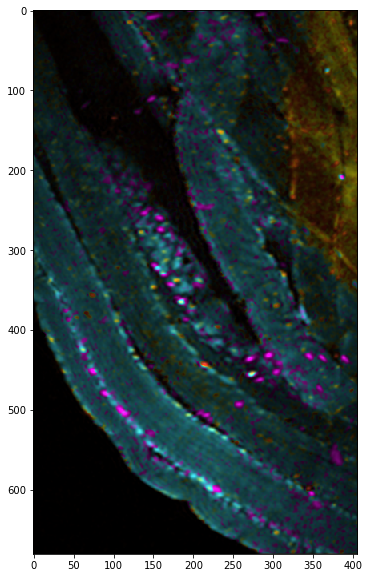

In [113]:
def generate_z_image_ensembled(ind, models):
    print(len(models))
    nb,ny,nx,nch = img_stack.shape
    img = np.zeros((len(models),ny,nx,nch_bottleneck))
    for i, model in enumerate(models):
        data = img_stack[ind,:,:,:]
        data = data[None,:]
        data = data.to(device)
        out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
        out = out[0,model.indices[0:nch_bottleneck],:,:]
        out = torch.permute(out, (1,2,0))
        img[i] =out.detach().cpu().numpy()
        #img[i] = out.detach().cpu().numpy()
        
    #img = img/len(models)
    img = np.mean(img,axis=0).squeeze()
    img[np.isnan(img)]=0
    #mg = np.median(img,axis=0).squeeze()
    #nbin = 50
    #ret = mode((nbin*img).astype(np.int),axis=0)
    #img = ret.mode.astype(np.float)/nbin
    
    ny,nx,nch = img.shape
    img_recolor = np.zeros((ny,nx,3))
    img_recolor[:,:,0] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,1]
    img_recolor[:,:,2] += img[:,:,1]
    img_recolor[:,:,2] += img[:,:,2]
    img_recolor[:,:,0] += img[:,:,2]
    if nch_bottleneck > 3:
        img_recolor[:,:,0] += img[:,:,3]
    #img_recolor[:,:,1] += img[:,:,4]
    return img_recolor

def generate_w_ensembled(models):
    wlist = np.zeros((len(models),9,nch_bottleneck))
    for i,model in enumerate(models):
        w = model.getSOEMlayer().weight
        w = w[:,model.indices]
        w = w.detach().cpu().numpy().squeeze()
        w[np.isnan(w)]=0
        wlist[i,:,:] = w
        #
        
    return np.mean(wlist,axis=0)
    #return wlist
        
minpr = np.percentile(relprob,90)
models_sel = []
for i in range(n_runs):
    if relprob[i] >= minpr:
        models_sel.append(models[i])

print(len(models_sel))
        
tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
w = generate_w_ensembled(models_sel)
print(w.shape)
alph = 20/len(models)
#alph=0.03
ax=plt.axes()
ax.set_facecolor('black')
plt.plot(tau,w[:,0],color='yellow')
plt.plot(tau,w[:,1],color='cyan')
plt.plot(tau,w[:,2],color='magenta')
if nch_bottleneck > 3:
    plt.plot(tau,w[:,3],color='red')
    #
#for i in range(len(models)):
#    plt.plot(tau,w[i,:,0],color='yellow',alpha=alph)
#    plt.plot(tau,w[i,:,1],color='cyan',alpha=alph)
#    plt.plot(tau,w[i,:,2],color='magenta',alpha=alph)
    #plt.plot(tau,w[i,:,3],color='red',alpha=alph)
    #plt.plot(tau,w[i,:,4],color='green',alpha=2*alph)
ax.set_xlim([-2,14])
ax.set_ylim([-0.05,0.6])
plt.show()
                     

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_ensembled(0,models_sel))
plt.show()

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_ensembled(1,models_sel))
plt.show()

#plt.figure(figsize=[8,10])
#plt.imshow(generate_z_image_ensembled(2,models))
#plt.show()

#plt.figure(figsize=[8,10])
#plt.imshow(generate_z_image_ensembled(5,models))
#plt.show()

In [35]:
models[1]

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): Hardtanh(min_val=-1.0, max_val=1.0)
    (12): AbsActivation()
  )
  (cnn_spectral_layers): Sequential(
    (0): ParametrizedConv2d(
      4, 9, kernel_size=(1, 1), stride=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): NormalizeEndmembers()
        )
      )
    )
    (1): ScalableSat(
      (tanh): Hardtanh(min_val=-1.0, max_val=1.0)
    )
  )
)

[[0. 1. 2. 3.]
 [0. 1. 3. 2.]
 [0. 2. 1. 3.]
 [0. 2. 3. 1.]
 [0. 3. 1. 2.]
 [0. 3. 2. 1.]
 [1. 0. 2. 3.]
 [1. 0. 3. 2.]
 [1. 2. 0. 3.]
 [1. 2. 3. 0.]
 [1. 3. 0. 2.]
 [1. 3. 2. 0.]
 [2. 0. 1. 3.]
 [2. 0. 3. 1.]
 [2. 1. 0. 3.]
 [2. 1. 3. 0.]
 [2. 3. 0. 1.]
 [2. 3. 1. 0.]
 [3. 0. 1. 2.]
 [3. 0. 2. 1.]
 [3. 1. 0. 2.]
 [3. 1. 2. 0.]
 [3. 2. 0. 1.]
 [3. 2. 1. 0.]]


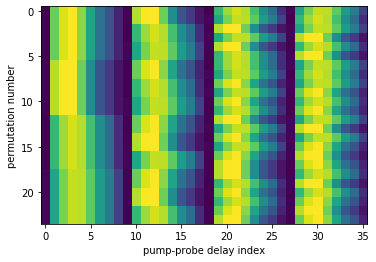

In [102]:
from itertools import permutations

permobj = permutations([0,1,2,3])
nperms = np.math.factorial(nch_bottleneck)
perms = np.zeros((nperms,nch_bottleneck))
for iperm,perm in enumerate(permobj):
    perms[iperm,:] = perm
    
model = models[1]

w = model.getSOEMlayer().weight
wlist = np.zeros((nperms,9,nch_bottleneck))

for iperm,perm in enumerate(perms):
    wlist[iperm,:,:] = w[:,perm].squeeze().cpu().detach().numpy()
    
wlist = wlist.swapaxes(2,1).reshape([nperms,9*nch_bottleneck])
wlist[np.isnan(wlist)] = 0
    
plt.imshow(wlist)
plt.ylabel('permutation number')
plt.xlabel('pump-probe delay index')
plt.show()

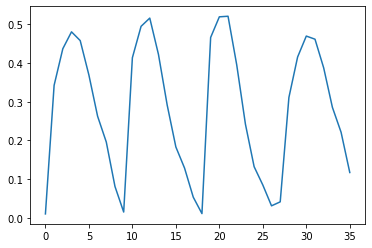

In [69]:
wref = models[ind_ml].getSOEMlayer().weight[:,models[ind_ml].indices].cpu().detach().numpy().squeeze()
wref=wref[None,:]
wref = wref.swapaxes(2,1).reshape([1,9*nch_bottleneck])
wref.shape
plt.plot(wref.T)

In [107]:
ind_matching_perm = np.argmax(np.sum(wlist * wref,1))
print(ind_matching_perm)
perms[ind_matching_perm]

12


array([2., 0., 1., 3.])

In [104]:
perms[12]

array([2., 0., 1., 3.])

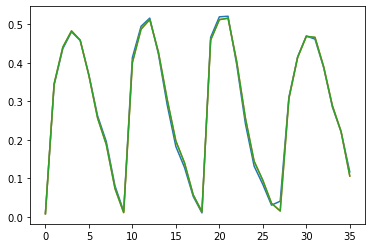

In [106]:
wvarsrt = model.getSOEMlayer().weight[:,model.indices].cpu().detach().numpy().squeeze()
wvarsrt=wvarsrt[None,:]
wvarsrt = wvarsrt.swapaxes(2,1).reshape([1,9*nch_bottleneck])

plt.plot(wref.T)
plt.plot(wlist[12,:].T)
plt.plot(wvarsrt.T)
plt.show()

In [108]:
# reference model (most likely)
wref = models[ind_ml].getSOEMlayer().weight[:,models[ind_ml].indices].cpu().detach().numpy().squeeze()
wref=wref[None,:]
wref = wref.swapaxes(2,1).reshape([1,9*nch_bottleneck])

# permutations set-up
permobj = permutations([0,1,2,3])
nperms = np.math.factorial(nch_bottleneck)
perms = np.zeros((nperms,nch_bottleneck))
for iperm,perm in enumerate(permobj):
    perms[iperm,:] = perm
    
# iterate through all models
for model in models:

    w = model.getSOEMlayer().weight
    wlist = np.zeros((nperms,9,nch_bottleneck))

    # generate permutations of endmembers for this model
    for iperm,perm in enumerate(perms):
        wlist[iperm,:,:] = w[:,perm].squeeze().cpu().detach().numpy()

    wlist = wlist.swapaxes(2,1).reshape([nperms,9*nch_bottleneck])
    wlist[np.isnan(wlist)] = 0
    
    # find permutation that best matches the reference model
    ind_matching_perm = np.argmax(np.sum(wlist * wref,1))
    
    # store best-matching permutation in the model
    model.indices = perms[ind_matching_perm]
    
    

In [ ]:
def generate_z_image_std(ind, models):
    print(len(models))
    nb,ny,nx,nch = img_stack.shape
    img = np.zeros((len(models),ny,nx,nch_bottleneck))
    for i, model in enumerate(models):
        data = img_stack[ind,:,:,:]
        data = data[None,:]
        data = data.to(device)
        out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
        out = out[0,model.indices[0:nch_bottleneck],:,:]
        out = torch.permute(out, (1,2,0))
        img[i] =out.detach().cpu().numpy()
        #img[i] = out.detach().cpu().numpy()
        
    #img = img/len(models)
    img = np.std(img,axis=0).squeeze()
    img[np.isnan(img)]=0
    #mg = np.median(img,axis=0).squeeze()
    #nbin = 50
    #ret = mode((nbin*img).astype(np.int),axis=0)
    #img = ret.mode.astype(np.float)/nbin
    
    ny,nx,nch = img.shape
    img_recolor = np.zeros((ny,nx,3))
    img_recolor[:,:,0] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,0]
    img_recolor[:,:,1] += img[:,:,1]
    img_recolor[:,:,2] += img[:,:,1]
    img_recolor[:,:,2] += img[:,:,2]
    img_recolor[:,:,0] += img[:,:,2]
    if nch_bottleneck > 3:
        img_recolor[:,:,0] += img[:,:,3]
    #img_recolor[:,:,1] += img[:,:,4]
    return img_recolor

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_std(0,models_sel))
plt.show()

plt.figure(figsize=[8,10])
plt.imshow(generate_z_image_std(1,models_sel))
plt.show()


In [ ]:
for x in loss_arr:
    print("Loss: ", x[0])
    plt.subplot(1,2,1)
    plt.imshow(x[1])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(x[2])
    plt.axis('off')
    plt.show()

# Analyze trained models

In [ ]:
def basic_boxplot(dataList, expNameList, yRange, metric, dataNum, save=False):
    plt.figure(figsize=(18,6))
    plt.boxplot(dataList)
    plt.ylim(yRange)
    plt.grid()
    plt.xticks([i+1 for i in range(dataNum)], [expNameList[i] + ': ' + str(np.round(np.mean(dataList[i]),6)) for i in range(len(dataList))])
    if str(metric) == 'PSNR':
        plt.ylabel(str(metric) + ' dB')
    else:
        plt.ylabel(str(metric))
    plt.title(str(metric) + ' boxplots for different initialization techniques')
    if save:
        plt.savefig('Boxplot' + str(metric), dpi=100, bbox_inches='tight')
    plt.show()

In [ ]:
dataList = [loss_arr_xu, loss_arr_u, loss_arr_normal, loss_arr_constant, loss_arr_xn, loss_arr_ku, loss_arr_kn]
expNameList = ['xavier_uniform', 'uniform', "normal", 'constant', 'xavier normal', 'kaiming uniform', 'kaiming normal']
basic_boxplot(dataList, expNameList, [0, 0.002], 'Total Loss', 7, False)

# Experiment with new features

### Automated hyperparameter search

In [ ]:
loss_arr = []

# number of times the experiment is repeated
n_runs = 1
n_epochs = 200
learning_rate = 1e-2
nch_bottleneck = 3

print('Starting training of models on {}'.format(device))
n_count = 0
patch_arr = [20, 40, 60, 80, 100, 150, 200, 250]
for patch_size in patch_arr:
    print('Patch Size:', patch_size)
    model = Net()
    loss, img1, img2 = train_model(model, n_epochs, img_stack, learning_rate, patch_size)
    loss_arr.append((loss, img1, img2))
    n_count+=1